In [1]:
pip install transformers accelerate datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [3]:
# load dataset
dataset = load_dataset("hebashakeel/wellness_project_dataset")
dataset

README.md:   0%|          | 0.00/514 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/990 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/212 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/213 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 213
    })
})

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from transformers import AutoTokenizer, AutoModel

In [7]:
model_checkpoint = 'mental/mental-bert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Intellectual Aspect", 1: "Vocational Aspect", 2: "Spiritual Aspect", 3: "Physical Aspect", 4: "Social Aspect", 5: "Emotional Aspect"}
label2id = {"Intellectual Aspect": 0, "Vocational Aspect": 1, "Spiritual Aspect" : 2, "Physical Aspect": 3, "Social Aspect": 4, "Emotional Aspect":5 }

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=6, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [11]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/990 [00:00<?, ? examples/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 990
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 213
    })
})

In [12]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [14]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [15]:
text_list = dataset['train']['text'][0:5]
label = dataset['test']['labels'][0:5]
print(label)
print("Without Fine-tuning")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " ,predictions.tolist())

[3, 4, 2, 5, 4]
Without Fine-tuning
“I’m beginning to think that it’s nothing to do with my body. But my mind.” -  5
I’ve been stuck in the same job for years, and I feel like I’m not growing or learning anything new -  0
"If I told them I'm struggling with an eating disorder, what are they going to do to help me?" -  0
“I made friends with a girl later in CIT, A and it was good at first, but I wasn't feeling it anymore after a while, but I was scared to end it because I knew she would bully me. I ended it eventually and she's now bullying me even worse than I thought she would.” -  5
"My inner turmoil often resembles a high-speed train derailing at neck-breaking speeds, causing chaos and fear." -  5


In [16]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['query','key', 'value'])

In [17]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 225,798 || all params: 109,712,652 || trainable%: 0.2058


In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 8
num_epochs = 10

In [26]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
import wandb
wandb.init(mode='disabled')

In [28]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

<ipython-input-28-e8e4c1055773>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.918124,{'accuracy': 0.6698113207547169}
2,No log,0.912126,{'accuracy': 0.6698113207547169}
3,No log,0.976114,{'accuracy': 0.6415094339622641}
4,No log,1.184361,{'accuracy': 0.6650943396226415}
5,No log,1.283222,{'accuracy': 0.6698113207547169}
6,No log,1.267676,{'accuracy': 0.6415094339622641}
7,No log,1.418072,{'accuracy': 0.6509433962264151}
8,No log,1.520576,{'accuracy': 0.6320754716981132}
9,0.491300,1.618324,{'accuracy': 0.6415094339622641}
10,0.491300,1.648967,{'accuracy': 0.6509433962264151}


Trainer is attempting to log a value of "{'accuracy': 0.6698113207547169}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.6698113207547169}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.6415094339622641}" of type <clas

TrainOutput(global_step=620, training_loss=0.4084066206409085, metrics={'train_runtime': 133.5989, 'train_samples_per_second': 74.102, 'train_steps_per_second': 4.641, 'total_flos': 386102322967968.0, 'train_loss': 0.4084066206409085, 'epoch': 10.0})

In [29]:
text_list = dataset['test']['text']
label = dataset['test']['labels']
#print(label)
print("With Fine-tuning")
pred = []
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to('cuda')
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    pred.append(predictions.tolist())

With Fine-tuning


In [30]:
from sklearn.metrics import classification_report
print(classification_report(label,pred))

              precision    recall  f1-score   support

           0       0.54      0.68      0.60        19
           1       0.79      0.96      0.86        23
           2       0.52      0.59      0.55        27
           3       0.77      0.72      0.75        47
           4       0.84      0.80      0.82        64
           5       0.40      0.30      0.34        33

    accuracy                           0.69       213
   macro avg       0.64      0.68      0.65       213
weighted avg       0.68      0.69      0.68       213



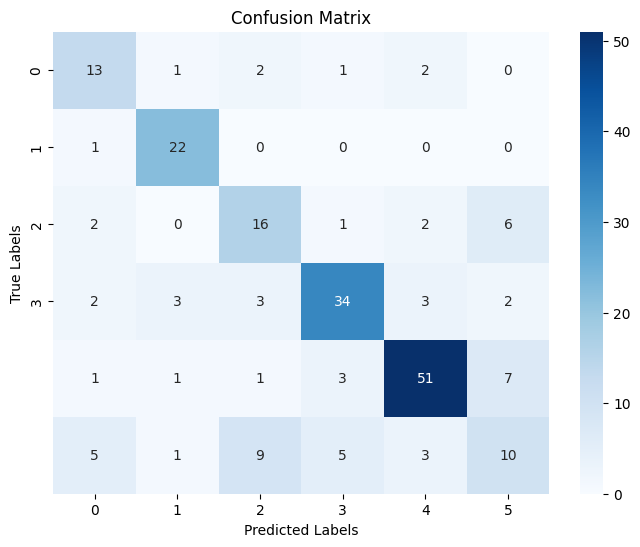

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(label, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(4))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()